In [33]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob

In [34]:
# calibrate the camera
nx = 9
ny = 6
objpoints = []
imgpoints = []

objp = np.zeros((nx * ny, 3), dtype=np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

for impath in glob('camera_cal/*.jpg'):
    # Find the chessboard corners
    gray = cv2.cvtColor(cv2.imread(impath), cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret is True:
        imgpoints.append(corners)
        objpoints.append(objp)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# 2. use a function from one of the quizes, skip params
def cal_undistort(img):
    # Use cv2.calibrateCamera() and cv2.undistort()
    return cv2.undistort(img, mtx, dist, None, mtx)

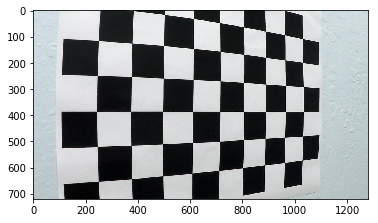

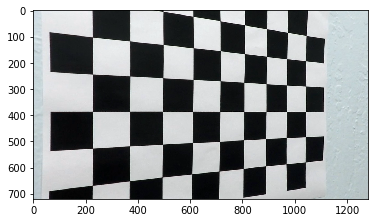

In [35]:
# demo cal_undistort
img = cv2.imread('camera_cal/calibration5.jpg')
plt.imshow(img)
plt.show()
plt.imshow(cal_undistort(img))
plt.show()

In [36]:
# util functions to combine sobel kernel gradient with saturation thresholding
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    x = int(orient == 'x')
    y = int(orient == 'y')
    abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, x, y, ksize=sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    mask = (scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[mask] = 1
    return binary_output

def hls_select(img, thresh=(0, 255)):
    S = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    mask = (S > thresh[0]) & (S <= thresh[1])
    binary_output = np.zeros_like(S)
    binary_output[mask] = 1
    return binary_output

In [37]:
# combine all preprocessing in one call
def preprocess(img):
    tmp = cal_undistort(img)
    hls = hls_select(tmp, thresh=(140,255))
    mag = abs_sobel_thresh(tmp, orient='x',
                       sobel_kernel=5,
                       thresh=(40,255))
    combined = np.zeros_like(hls)
    combined[(hls == 1) | (mag == 1)] = 1
    return combined

(720, 1280, 3)


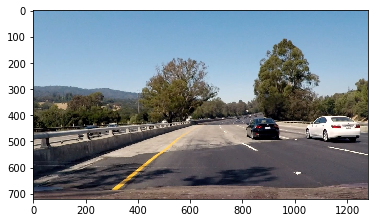

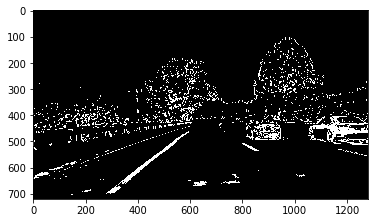

In [38]:
# demo preprocess
im_orig = cv2.imread('test_images/test4.jpg')
im_orig = cv2.cvtColor(im_orig, cv2.COLOR_BGR2RGB)
print(im_orig.shape)
plt.imshow(im_orig)
plt.show()

plt.imshow(preprocess(im_orig), cmap='gray')
plt.show()

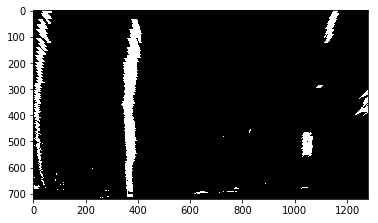

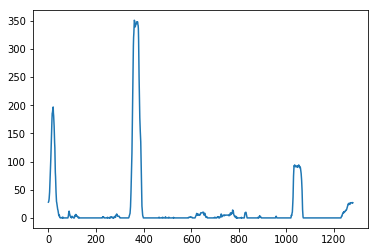

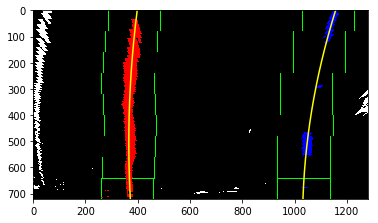

In [39]:
img = preprocess(im_orig)
img_size = (img.shape[1], img.shape[0])
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 20), img_size[1]],
    [(img_size[0] * 5 / 6) + 20, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

M = cv2.getPerspectiveTransform(src, dst)
binary_warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)
# plt.imshow(binary_warped, cmap='gray')
# plt.show()

out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
# plt.plot(histogram)
# plt.show()

x_midpoint = np.int(histogram.shape[0] / 2)
leftx_base = np.argmax(histogram[:x_midpoint])
rightx_base = np.argmax(histogram[x_midpoint:]) + x_midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
#     cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
#     cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
# out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
# plt.imshow(out_img)
# plt.plot(left_fitx, ploty, color='yellow')
# plt.plot(right_fitx, ploty, color='yellow')
# plt.xlim(0, 1280)
# plt.ylim(720, 0)
# plt.show()

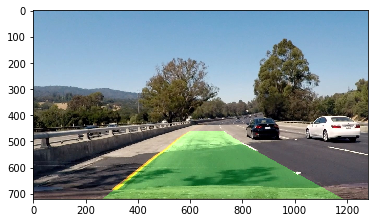

In [40]:
# draw predicted lines on the original unwarped image - copy from example
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
Minv = np.linalg.inv(M)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(im_orig, 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.show()

In [43]:
def process_frame(im_orig):
    img = preprocess(im_orig)
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 20), img_size[1]],
        [(img_size[0] * 5 / 6) + 20, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])

    M = cv2.getPerspectiveTransform(src, dst)
    binary_warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)

    x_midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:x_midpoint])
    rightx_base = np.argmax(histogram[x_midpoint:]) + x_midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = np.linalg.inv(M)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    return cv2.addWeighted(im_orig, 1, newwarp, 0.3, 0)

In [44]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_frame)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [04:23<00:00,  5.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 4min, sys: 1min 16s, total: 5min 17s
Wall time: 4min 25s


In [45]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))